In [1]:
 """    
 
 linear program:
 
 min. c^T*x
 s.t. A_ub*x <= b_ub, A_eq*x == b_eq
 
 Our case:
 min \sum_{i=1}^p mu_i 
 s.t. eta_i <= mu_i
      -eta_i <= mu_i
      T = \sum eta_i O_i   where O_i = D\circ P_i  (O_i: n qubit -> n qubit, T: target)

x = [mu_i, eta_i]
c = [1, 1,..., 0, 0,...]
(2p elements)
A_ub = [[-1, 0,..., 1, 0,...],
        [0, -1,..., 0, 1,...],
        ...
        [-1, 0,...,-1, 0,...],
        [0, -1,..., 0, -1...],
        ...
        ]
(2p x 2p)
b_ub = [0,...,0]
(2p elements)
A_eq = [[0,...,0, O_0[0,0], O_1[0,0],...,O_p[0,0]],
        [0,...,0, O_0[1,1], O_1[1,1],...,O_p[1,1]],
        [0,...,0, O_0[2^(2n),2^(2n)], O_1[2^(2n),2^(2n)],...,O_p[2^(2n),2^(2n)]],
        ...
        [0,...,0, O_0[0,1].real, O_1[0,1].real,...,],
        ...
        [0,...,0, O_0[2^(2n)-1,2^(2n)].real, O_1[2^(2n)-1,2^(2n)].real,...,],
        [0,...,0, O_0[0,1].imag, O_1[0,1].imag,...,],
        ...
        [0,...,0, O_0[2^(2n)-1,2^(2n)].imag, O_1[2^(2n)-1,2^(2n)].imag,...,]
        ]
(2^(2n) x 2p)
b_eq = [T[0,0], T[1,1],...,T[2^(2n),2^(2n)], T[0,1].real.,... T[2^(2n)-1,2^(2n)].real, T[0,1].imag,... T[2^(2n)-1,2^(2n)].imag]
(2^(2n) elements)
where O_alpha[i,j] is (i,j) element of the Choi state for O_alpha and only take i<= j (because O_alpha is Hermitian)

"""

'    \n\nlinear program:\n\nmin. c^T*x\ns.t. A_ub*x <= b_ub, A_eq*x == b_eq\n\nOur case:\nmin \\sum_{i=1}^p mu_i \ns.t. eta_i <= mu_i\n     -eta_i <= mu_i\n     T = \\sum eta_i O_i   where O_i = D\\circ P_i  (O_i: n qubit -> n qubit, T: target)\n\nx = [mu_i, eta_i]\nc = [1, 1,..., 0, 0,...]\n(2p elements)\nA_ub = [[-1, 0,..., 1, 0,...],\n       [0, -1,..., 0, 1,...],\n       ...\n       [-1, 0,...,-1, 0,...],\n       [0, -1,..., 0, -1...],\n       ...\n       ]\n(2p x 2p)\nb_ub = [0,...,0]\n(2p elements)\nA_eq = [[0,...,0, O_0[0,0], O_1[0,0],...,O_p[0,0]],\n       [0,...,0, O_0[1,1], O_1[1,1],...,O_p[1,1]],\n       [0,...,0, O_0[2^(2n),2^(2n)], O_1[2^(2n),2^(2n)],...,O_p[2^(2n),2^(2n)]],\n       ...\n       [0,...,0, O_0[0,1].real, O_1[0,1].real,...,],\n       ...\n       [0,...,0, O_0[2^(2n)-1,2^(2n)].real, O_1[2^(2n)-1,2^(2n)].real,...,],\n       [0,...,0, O_0[0,1].imag, O_1[0,1].imag,...,],\n       ...\n       [0,...,0, O_0[2^(2n)-1,2^(2n)].imag, O_1[2^(2n)-1,2^(2n)].imag,...,]\n   

In [71]:
"""
Functions: Run this cell first
"""

from qutip import *
import numpy as np
from qulacs import DensityMatrix, QuantumCircuit
from qulacs.gate import Identity, X, Y, Z, DenseMatrix, CPTP, H
from scipy.optimize import *
import matplotlib.pyplot as plt


def v_to_choi(MyList):
    return [to_choi(item) for item in MyList]


"""
In: Target operation and list of noisy operaions in any Qutip form (Kraus, Choi, process matrix)
Out: Output of linear programming (eta, gamma) for the affine decomposition of the target operation w.r.t 
    the noisy basis operations (cf. Temme et al. PRL 119, 180509 (2017))
"""

def aff_decomp(targ, BaseOp): 
    #targ:target map with single Kraus Op or Choi form, BaseOp:list of maps with single Kraus Op or Choi form    
    # Transform everything into Choi matrix 
    targ_choi = to_choi(targ)
    BaseOp_choi = v_to_choi(BaseOp)

    # Convert Qobj in QuTip to ndarray  
    targ_choi_nd = targ_choi.full()
    BaseOp_choi_nd = np.array([qobj.full() for qobj in BaseOp_choi])


    # Linear program
    p = BaseOp_choi_nd.shape[0] #number of noisy operations
    q = BaseOp_choi_nd.shape[1] #size of each noisy operation
    c = [1 if i<=p-1 else 0 for i in range(0,2*p)]
    A_u = [[-1 if i==j else 1 if i==j+p else 0 for i in range(0,2*p)] if j<=p-1 else\
           [-1 if i==j-p or i==j else 0 for i in range(0,2*p)] for j in range(0,2*p)]
    b_u = [0 for i in range(0, 2*p)]
    A_e_diag = [[0 if i<=p-1 else BaseOp_choi_nd[i-p,j,j].real for i in range(0,2*p)] \
            for j in range(0,q)]
    A_e_real = [[0 if i<=p-1 else BaseOp_choi_nd[i-p,j,k].real for i in range(0,2*p)] \
            for j in range(0,q) for k in range(j+1,q)]
    A_e_imag = [[0 if i<=p-1 else BaseOp_choi_nd[i-p,j,k].imag for i in range(0,2*p)] \
            for j in range(0,q) for k in range(j+1,q)]
    A_e = np.concatenate((A_e_diag, A_e_real, A_e_imag))
    b_e_diag = [targ_choi_nd[j,j].real for j in range(0,q)]
    b_e_real = [targ_choi_nd[j,k].real for j in range(0,q) for k in range(j+1,q)]
    b_e_imag = [targ_choi_nd[j,k].imag for j in range(0,q) for k in range(j+1,q)]
    b_e = np.concatenate((b_e_diag, b_e_real, b_e_imag)).flatten()
    bounds_list = [(None, None) for j in range(0,2*p)]
    
    opt = linprog(c, A_ub=A_u, b_ub=b_u, A_eq=A_e, b_eq=b_e, bounds=bounds_list,\
                  options = {'tol': 10**(-8)})
    if opt.success == False:
        print(opt.message)
    
    gamma = opt.fun
    Eta = np.array([opt.x[j] for j in range(p, 2*p)])
    
    return [gamma, np.around(Eta, decimals=10)] 

"""
Noisy version of Basis Operations (Add noisy target operation to Basis)
"""

def aff_decomp_noise(targ, BaseOp, Noise): #targ, BaseOp and Noise should be in Kraus form
        #Add target gate to Base operations
        BaseOp.append(targ)
        #Convert elements of Base operations into list
        BaseOp = [item if isinstance(item, list) else [item] for item in BaseOp]
        #Apply noise after Base operations
#         noise_choi = sum(v_to_choi(Noise))
#         Noise_kraus = to_kraus(noise_choi)   #to_kraus does not preserve the tensor product structure in Choi form
        Noise_kraus = Noise
#         NoisyBaseOp_kraus = [[kraus * base for kraus in Noise_kraus] for base in BaseOp]
        NoisyBaseOp_kraus = [[kraus * base_kraus for base_kraus in base for kraus in Noise_kraus] for base in BaseOp]
        NoisyBaseOp_choi = [sum(v_to_choi(item)) for item in NoisyBaseOp_kraus]
        return aff_decomp(targ, NoisyBaseOp_choi) #The last item of Eta corresponds to the noisy target 
    

"""
Basis by Endo et al. PRX 8, 31027 (2018) 
"""

def Base_Endo():
    Rx = (1/np.sqrt(2))*(qeye(2) + 1j*sigmax())
    Ry = (1/np.sqrt(2))*(qeye(2) + 1j*sigmay())
    Rz = (1/np.sqrt(2))*(qeye(2) + 1j*sigmaz())

    Ryz = (1/np.sqrt(2))*(sigmay() + sigmaz())
    Rzx = (1/np.sqrt(2))*(sigmaz() + sigmax())
    Rxy = (1/np.sqrt(2))*(sigmax() + sigmay())

    Pix = (1/2)*(qeye(2) + sigmax())
    Piy = (1/2)*(qeye(2) + sigmay())
    Piz = (1/2)*(qeye(2) + sigmaz())
    Piyz = (1/2)*(sigmay() + 1j*sigmaz())
    Pizx = (1/2)*(sigmaz() + 1j*sigmax())
    Pixy = (1/2)*(sigmax() + 1j*sigmay())

    return [qeye(2), sigmax(), sigmay(), sigmaz(), Rx, Ry, Rz, Ryz, Rzx, Rxy, \
                       Pix, Piy, Piz, Piyz, Pizx, Pixy]


def Base_Endo_rev():
    #add CPTP maps
    Basetemp = Base_Endo()
    Pix = (1/2)*(qeye(2) + sigmax())
    Piy = (1/2)*(qeye(2) + sigmay())
    Piz = (1/2)*(qeye(2) + sigmaz())
    Piyz = (1/2)*(sigmay() + 1j*sigmaz())
    Pizx = (1/2)*(sigmaz() + 1j*sigmax())
    Pixy = (1/2)*(sigmax() + 1j*sigmay())
    Basetemp.append([Pix, Piyz])
    Basetemp.append([Piy, Pizx])
    Basetemp.append([Piz, Pixy])
    return Basetemp

"""
Tensoring basis operations
"""
def Base_tensor(BaseOp, nqubit):
#     Basetemp = BaseOp
    Base_list = [item if isinstance(item, list) else [item] for item in BaseOp]
    Basetemp = Base_list
    for j in range(nqubit-1):
        Basetemp = [[tensor(op1, op2) for op1 in Basetemp_item for op2 in Base_item]\
                    for Basetemp_item in Basetemp for Base_item in Base_list]
    return Basetemp

In [59]:

"""
Example 1: single-qubit depolarizing followed by Pauli 
"""

#Specify dimension of the system d = 2^n
nqubit = 1
dim = 2**nqubit

#Specify Kraus operators for each CPTP map
Paulis = [qeye(dim), sigmax(), sigmay(), sigmaz()]
p0 = 2/3  #1/4< p0 <=1
p1 = p2 = p3 = (1-p0)/(4**nqubit - 1)
Dep_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p1)*sigmax(), np.sqrt(p2)*sigmay(), np.sqrt(p3)*sigmaz()]
# Dep_Pauli_kraus = np.array([[pauli * dep_kraus for dep_kraus in Dep_kraus] for pauli in Paulis], dtype=Qobj)
Dep_Pauli_kraus = [[pauli * dep_kraus for dep_kraus in Dep_kraus] for pauli in Paulis]

Dep_Pauli_kraus_choi = [sum(v_to_choi(dep_pauli_kraus)) for dep_pauli_kraus in Dep_Pauli_kraus]

# Input in any form
targ_test = qeye(dim)
Noisy_test = Dep_Pauli_kraus_choi


#test
targ = targ_test
Noisy = Noisy_test
# Transform everything into Choi matrix 
targ_choi = to_choi(targ)
Noisy_choi = v_to_choi(Noisy)

# Convert Qobj in QuTip to ndarray  
targ_choi_nd = targ_choi.full()
Noisy_choi_nd = np.array([qobj.full() for qobj in Noisy_choi])

# Plug into the function
aff_singledep = aff_decomp(targ_test, Noisy_test)
print(aff_singledep)

[2.200000015350578, array([ 1.59999998, -0.2       , -0.2       , -0.2       ])]


/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


Reproduced Temme et al. PRL 119, 180509 (2017)

In [26]:
"""
Example 2: two-qubit depolarizing followed by Pauli 
"""

#Specify dimension of the system d = 2^n
nqubit = 2
dim = 2**nqubit

#Specify Kraus operators for each CPTP map
SinglePaulis = [qeye(2), sigmax(), sigmay(), sigmaz()]
Paulis = [tensor(pauli1, pauli2) for pauli1 in SinglePaulis for pauli2 in SinglePaulis] 

p0 = 2/3  #1/4^(nqubit)< p0 <=1
plist = [(1-p0)/(4**nqubit-1) for j in range(len(Paulis))]
plist[0] = p0
TwoDep_kraus = [np.sqrt(plist[j])*Paulis[j] for j in range(len(Paulis))]
TwoDep_Pauli_kraus = [[pauli * dep_kraus for dep_kraus in TwoDep_kraus] for pauli in Paulis]

TwoDep_Pauli_choi = [sum(v_to_choi(dep_pauli_kraus)) for dep_pauli_kraus in TwoDep_Pauli_kraus]

# Input in any form
targ_test = qeye(dim)
Noisy_test = TwoDep_Pauli_choi

# Plug into the function
aff_decomp(targ_test, Noisy_test)

/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[2.034482758618845,
 array([ 1.51724138, -0.03448276, -0.03448276, -0.03448276, -0.03448276,
        -0.03448276, -0.03448276, -0.03448276, -0.03448276, -0.03448276,
        -0.03448276, -0.03448276, -0.03448276, -0.03448276, -0.03448276,
        -0.03448276])]

Extended to two-qubit depolarizing channel using the same type of basis as above 

In [29]:
"""
Using basis by Endo et al. PRX 8, 31027 (2018) 
"""

BaseOp = Base_Endo()

nqubit = 1
dim = 2**nqubit

targ_test = phasegate(np.pi/4)
Noisy_test = BaseOp

# Plug into the function
opt = aff_decomp(targ_test, Noisy_test)
print(opt)


"""
Noisy version of Basis Operations (Add noisy target operation to Basis)
"""

#Example: depolarizing
nqubit = 1 
dim = 2**nqubit
p0 = 1 - 0.1  #1/4< p0 <=1
p1 = p2 = p3 = (1-p0)/(4**nqubit - 1)
Dep_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p1)*sigmax(), np.sqrt(p2)*sigmay(), np.sqrt(p3)*sigmaz()]

NoiseSingle_kraus = Dep_kraus
targ_test = phasegate(np.pi/4)
opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)



[2.414213560125665, array([ 1.20710678, -0.        , -0.        ,  0.5       ,  0.        ,
        0.        , -0.70710678,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ])]
[1.2439671438975544, array([ 9.00000000e-10, -3.84615384e-02, -3.84615384e-02, -2.25302472e-02,
        0.00000000e+00,  0.00000000e+00, -2.25302481e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.12198357e+00])]


Using basis by Endo et al. PRX 8, 31027 (2018) 
 * Decomposed T gate with Endo's basis
 * Decomposed T gate with noisy Endo's basis + noisy T gate  

In [35]:
# Example: amplitude damping 

BaseOp = Base_Endo()
# Prep0 = [ket2dm(basis(2,0)), basis(2,0)*basis(2,1).dag()]
# BaseOp.append(Prep0)

nqubit = 1 
dim = 2**nqubit
eps = 1/2
amp_kraus0 = basis(dim, 0)*basis(dim,0).dag() + np.sqrt(1-eps)*basis(dim, 1)*basis(dim,1).dag()
amp_kraus1 = np.sqrt(eps)*basis(dim, 0)*basis(dim,1).dag()
Amp_kraus = [amp_kraus0, amp_kraus1]

NoiseSingle_kraus = Amp_kraus
targ_test = qeye(2)
opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)

[3.999999999324225, array([ 0.85355339,  0.        ,  0.        ,  0.29289322, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -1.        ,  0.        , -0.        ,
       -1.        ,  0.85355339])]


Reproduces the performance of the example in Temme et al.
Note that |0><0| and |0><1| are considered as separate CP trace non-increasing maps so their coefficients are separately summed up, while in Temme et al. they used |0><0|+|0><1| as one CPTP map (|0> preparation)

In [31]:
# Multi qubits: Use Base_tensor to tensoring basis operations. 

nqubit = 2
dim = 2**nqubit

# Two-qubit depolazing
SinglePaulis = [qeye(2), sigmax(), sigmay(), sigmaz()]
Paulis = [tensor(pauli1, pauli2) for pauli1 in SinglePaulis for pauli2 in SinglePaulis]

p0 = 2/3  #1/4^(nqubit)< p0 <=1
plist = [(1-p0)/(4**nqubit-1) for j in range(len(Paulis))]
plist[0] = p0
TwoDep_kraus = [np.sqrt(plist[j])*Paulis[j] for j in range(len(Paulis))]

NoiseTwo_kraus = TwoDep_kraus
targ_test = cnot()
opt = aff_decomp_noise(targ_test, Base_tensor(Base_Endo(), nqubit), NoiseTwo_kraus)
print(opt)


[2.1034482715387957, array([-3.44827586e-02, -3.44827586e-02, -3.44827586e-02, -3.44827586e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.00000000e-10, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -3.44827586e-02, -3.44827586e-02, -3.44827586e-02, -3.44827586e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.44827586e-02, -3.44827586e-02, -3.44827586e-02, -3.44827586e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -3.44827586e-02, -3.44827587e-02, -3.44827586e-02, -3.44827586e-02,
    

In [55]:
# Two-qubit amplitude dampling
eps = 1/2
amp_kraus0 = basis(2, 0)*basis(2,0).dag() + np.sqrt(1-eps)*basis(2, 1)*basis(2,1).dag()
amp_kraus1 = np.sqrt(eps)*basis(2, 0)*basis(2,1).dag()
Amp_kraus = [amp_kraus0, amp_kraus1]
TwoAmp_kraus = [tensor(kraus1, kraus2) for kraus1 in Amp_kraus for kraus2 in Amp_kraus]

NoiseTwo_kraus = TwoAmp_kraus
targ_test = tensor(qeye(2), qeye(2))
opt = aff_decomp_noise(targ_test, Base_tensor(Base_Endo(), nqubit), NoiseTwo_kraus)
print(opt)

[21.94974746845684, array([ 0.35355339,  0.85355339,  0.29289322,  0.        , -0.        ,
       -0.35355339,  0.        ,  0.20710678, -0.35355339, -0.        ,
       -0.70710678,  0.        , -1.        ,  0.29289322,  0.        ,
       -1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.35355339,  0.14644661,
        0.08578644, -0.20710678, -0.        ,  0.35355339,  0.        ,
        0.20710678,  0.35355339,  0.        ,  0.70710678,  0.        ,
       -1.        , -0.29289322,  0.        , -1.        , -0.        ,
       -0.        , -0.        , -0.        

Contributions of trace non-incresing maps make gamma quite large

In [40]:
"""Using revised basis of Endo's"""
# Example: amplitude damping 

BaseOp = Base_Endo_rev()

nqubit = 1 
dim = 2**nqubit
eps = 1/2
amp_kraus0 = basis(dim, 0)*basis(dim,0).dag() + np.sqrt(1-eps)*basis(dim, 1)*basis(dim,1).dag()
amp_kraus1 = np.sqrt(eps)*basis(dim, 0)*basis(dim,1).dag()
Amp_kraus = [amp_kraus0, amp_kraus1]

NoiseSingle_kraus = Amp_kraus
targ_test = qeye(2)
opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)

[2.999999994585732, array([ 8.53553390e-01,  0.00000000e+00,  0.00000000e+00,  2.92893219e-01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.60000000e-09, -0.00000000e+00, -0.00000000e+00, -1.60000000e-09,
       -0.00000000e+00, -0.00000000e+00, -9.99999998e-01,  8.53553390e-01])]


Improved the performance by not using trace nonincreasing map

In [54]:
# Two-qubit amplitude dampling
nqubit = 2
eps = 1/2
amp_kraus0 = basis(2, 0)*basis(2,0).dag() + np.sqrt(1-eps)*basis(2, 1)*basis(2,1).dag()
amp_kraus1 = np.sqrt(eps)*basis(2, 0)*basis(2,1).dag()
Amp_kraus = [amp_kraus0, amp_kraus1]
TwoAmp_kraus = [tensor(kraus1, kraus2) for kraus1 in Amp_kraus for kraus2 in Amp_kraus]

NoiseTwo_kraus = TwoAmp_kraus
targ_test = tensor(qeye(2), qeye(2))
opt = aff_decomp_noise(targ_test, Base_tensor(Base_Endo_rev(), nqubit), NoiseTwo_kraus)
print(opt)

[9.000000000012133, array([ 1.45710678, -0.        ,  0.        ,  0.5       , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -1.70710678, -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.5       ,  0.        ,  0.        ,
        0.08578644, -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        

/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.


Also a significant improvement over the original Endo's basis

[1.0204081640683165, array([-0.00510204, -0.        ,  0.        ,  1.01020408,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.00510204])]
[1.2012321564428303, array([-0.00510204, -0.090412  , -0.        ,  0.899588  ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.20102807,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.00510204])]


/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/Users/ryuji/anaconda3/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.93769e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/ryuji/anaconda3/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.76623e-20): result

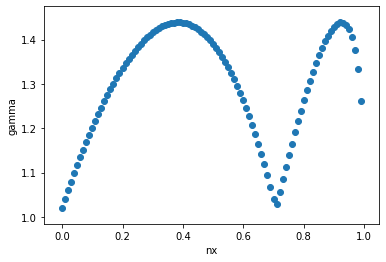

In [85]:
"""
Explore better basis
"""

BaseOp = Base_Endo_rev()

#Example: phase flip

p0 = 0.01 
p3 = 1-p0
Phase_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p3)*sigmaz()]

NoiseSingle_kraus = Phase_kraus
targ_test = qeye(2)
opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)


#Example: flip w.r.t tilted axis

BaseOp = Base_Endo_rev()

nx = 0.1
ny = 0.0
nz = np.sqrt(1.0 - ny**2 - nx**2)

axis_op = nx*sigmax() + ny*sigmay() + nz*sigmaz()
Tilted_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p3)*rotation(axis_op, np.pi)]

NoiseSingle_kraus = Tilted_kraus
targ_test = qeye(2)
opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)


#plot with various nx
dnx = 0.01
nx_max = 1
nx_list = []
gamma_list = []
nx = 0

while nx <= nx_max:
    ny = 0.0
    nz = np.sqrt(1.0 - ny**2 - nx**2)
    axis_op = nx*sigmax() + ny*sigmay() + nz*sigmaz()
    Tilted_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p3)*rotation(axis_op, np.pi)]
    NoiseSingle_kraus = Tilted_kraus
    targ_test = qeye(2)
    opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
     
    nx_list.append(nx)
    gamma_list.append(opt[0])
    nx += dnx

plt.scatter(nx_list, gamma_list)
plt.xlabel("nx")
plt.ylabel("gamma")
plt.show()

In [91]:
"""
Explore better basis
"""

#Example: depolarizing

BaseOp = Base_Endo_rev()

nqubit = 1 
dim = 2**nqubit
p0 = 1-0.1  #1/4< p0 <=1
p1 = p2 = p3 = (1-p0)/(4**nqubit - 1)
Dep_kraus = [np.sqrt(p0)*qeye(dim), np.sqrt(p1)*sigmax(), np.sqrt(p2)*sigmay(), np.sqrt(p3)*sigmaz()]

NoiseSingle_kraus = Dep_kraus
targ_test = qeye(2)

opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)


BaseOp = Base_Endo_rev()
BaseOp.append(Dep_kraus)

opt = aff_decomp_noise(targ_test, BaseOp, NoiseSingle_kraus)
print(opt)






/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/Users/ryuji/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.


[1.230769230768709, array([ 0.55769231, -0.03846154, -0.03846154, -0.03846154, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.55769231])]
[1.2307692307697446, array([ 0.55769231, -0.03846154, -0.03846154, -0.03846154,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.55769231])]


/Users/ryuji/anaconda3/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.35622e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
